# Regrese

## Zdroj dat

  * Zdrojem dat je soubor `LifeExpectancyData.csv` (originál zde: https://www.kaggle.com/kumarajarshi/life-expectancy-who).
  * Popis datasetu najdete na uvedené stránce s originálem datasetu.
  * Cílová (vysvětlovaná) proměnná se jmenuje `Life expectancy `.

# Zpracování

In [65]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_theme(style='darkgrid')

%matplotlib inline

In [66]:
# load dataset and replace empty values with np.nan
data = pd.read_csv('data.csv')
data = data.fillna(np.nan)

target = 'Life expectancy '

## Odstranění řádků bez vysvětlované proměnné
Jelikož se jedná o supervizované učení, tak jsou řádky bez vysvětlované proměnné zbytečné.

In [67]:
def delete_empty_target_rows(df, feature):
    """ Remove rows where selected feature is null """

    null_cnt = df[feature].isnull().sum()
    print(f'Removed {null_cnt} rows')
    
    data.drop(list(df[feature][df[feature].isnull()].index), axis=0, inplace=True)

In [68]:
delete_empty_target_rows(data, target)

Removed 0 rows


## Explorační analýza dat
Zde budeme primárně zaměřovat na chybějící hodnoty a distribuci či korelaci příznaků.

In [69]:
display(data.shape)
display(data.head())

(566, 22)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65.0,1154.0,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62.0,492.0,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64.0,430.0,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67.0,2787.0,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68.0,3013.0,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [70]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          566 non-null    object 
 1   Year                             566 non-null    int64  
 2   Status                           566 non-null    object 
 3   Life expectancy                  566 non-null    float64
 4   Adult Mortality                  566 non-null    int64  
 5   infant deaths                    566 non-null    int64  
 6   Alcohol                          532 non-null    float64
 7   percentage expenditure           566 non-null    float64
 8   Hepatitis B                      487 non-null    float64
 9   Measles                          565 non-null    float64
 10   BMI                             565 non-null    float64
 11  under-five deaths                565 non-null    float64
 12  Polio                 

Dataset obsahuje **22** příznaků včetně vystvětlované proměnné **Life expectancy**.
Dále obsahuje celkově **2928** záznamů.

### Přejmenování příznaků
Odstraníme zbytečné mezery a unifikujeme formát názvů.

In [71]:
data = data.rename(columns=lambda x : x.strip().lower())
target = 'life expectancy'

### Rozdělení na numerické a kategorické data
Rozdělíme si příznaky na numerické a kategorické. Od jejich typu se bude odvíjet následné zpracování.

In [72]:
categorical = list(data.select_dtypes('object').columns)
numerical = list(set(data.columns) - set(categorical + [target]))

print('Numerical:', len(categorical))
display(categorical)

print('Categorical:', len(numerical))
display(numerical)

Numerical: 2


['country', 'status']

Categorical: 19


['infant deaths',
 'diphtheria',
 'population',
 'bmi',
 'thinness 5-9 years',
 'hiv/aids',
 'percentage expenditure',
 'measles',
 'polio',
 'alcohol',
 'year',
 'hepatitis b',
 'thinness  1-19 years',
 'schooling',
 'adult mortality',
 'under-five deaths',
 'gdp',
 'income composition of resources',
 'total expenditure']

Dataset obsahuje **2 kategorické** a **19 numerických** příznaků.

### Chybějící hodnoty
Chybějící hodnoty vizualizujeme a vypíšeme v procentech o jakou část chybějících dat se jedná.

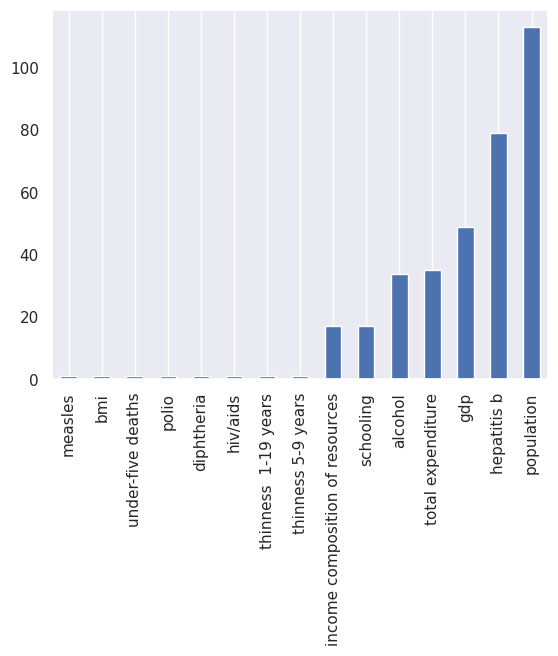

Features with missing values: 15

Missing:
measles                            : 0.177%
bmi                                : 0.177%
under-five deaths                  : 0.177%
polio                              : 0.177%
diphtheria                         : 0.177%
hiv/aids                           : 0.177%
thinness  1-19 years               : 0.177%
thinness 5-9 years                 : 0.177%
income composition of resources    : 3.004%
schooling                          : 3.004%
alcohol                            : 6.007%
total expenditure                  : 6.184%
gdp                                : 8.657%
hepatitis b                        : 13.958%
population                         : 19.965%


In [73]:
# get null values and sort them
missing = data.isnull().sum()
missing_cnt = data.shape[0]
missing = missing[missing > 0].sort_values()

# plot missing values
missing.plot.bar()
plt.grid(axis='y')
plt.show()

print("Features with missing values:", len(missing))

null_features = []
for feature in data.columns[data.isnull().any()]:
    null_features.append([feature, data[feature].isnull().sum()])

null_features.sort(key=lambda x: x[1])

print("\nMissing:")
for feature, null_cnt in null_features:
    print(f"{feature.strip(): <35}: {round(null_cnt / (missing_cnt / 100), 3)}%")

V datech u **14** příznaků chybí nějaké hodnoty.
Všechny příznaky, u kterých chybí nějaká hodnota, tak jsou numerické. To znamená, že bychom je mohli nahradit mediánem.

### Distribuce vysvětlované proměnné
U vysvětlované proměnné můžeme zkoumat, jestli se neřídí podle nějakého známého rozdělení.

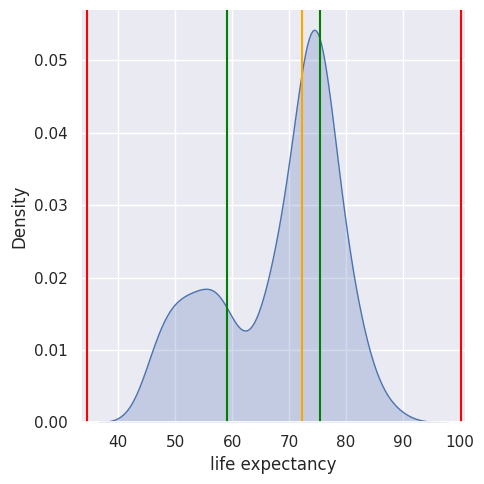

Median: 72.3
Lower quartile: 59.1
Upper quartile: 75.5
IQR: 16.4 - (34.5 , 100.1)


In [74]:
median = pd.Series.median(data[target])
Q1 = data[target].quantile(0.25)
Q3 = data[target].quantile(0.75)
IQR = round(Q3 - Q1, 2)

# target feature distribution with median
sns.displot(data, x=target, kind='kde', fill=True)

# quartiles
plt.axvline(Q1, color='green')
plt.axvline(Q3, color='green')

# outliers
l_bound, u_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
plt.axvline(l_bound, color='red')
plt.axvline(u_bound, color='red')

# median
plt.axvline(median, color='orange')
plt.show()

print('Median:', median)
print('Lower quartile:', Q1)
print('Upper quartile:', Q3)
print(f'IQR: {IQR} - ({l_bound} , {u_bound})')


Můžeme vidět, že vysvětlovaná proměnná se lehce podobá normálnímu rozdělení.
Čili naše predikovaná hodnota se bude pravděpodobně pohybovat v okolí mediánu (*oranžová čára*), které bych mohl odhadnout například horním a dolním kvartilem `[63.1 - 75.7]` (*zelené čáry*).

Dále můžeme vidět nějaké odlehlé hodnoty na intervalu `[0 - 44.2]` (*červené čáry*).

### Kategorické příznaky

#### Status
Jelikož je příznak kategorický a obsahuje pouze dvě unikátní hodnoty, tak si vykreslím graf s jejich rozdělením.
Následně by nás mohlo zajímat, jaká je distribuce vysvětlované proměnné na základě právě příznaku `status`.

In [75]:
data['status'].describe()

count            566
unique             2
top       Developing
freq             502
Name: status, dtype: object

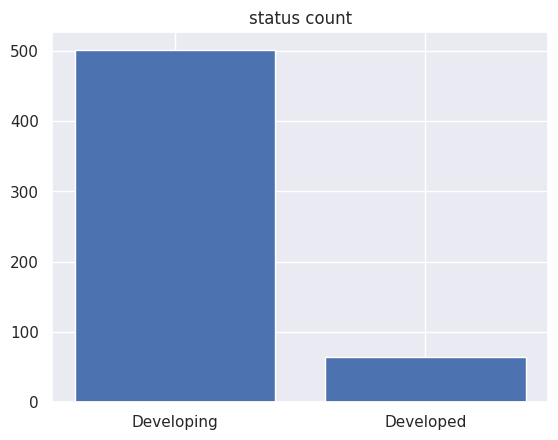

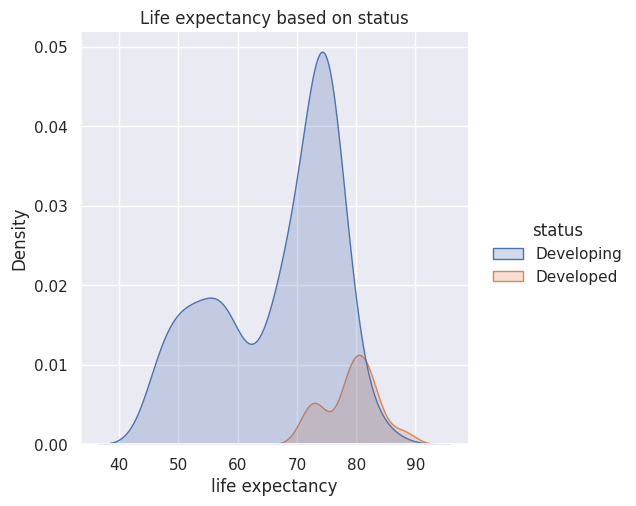

In [76]:
# count freq for each value
status_cnt = { 'Developing' : 0, 'Developed' : 0 }
for val in data['status']:
    status_cnt[val] += 1

# plot bar chart
plt.bar(list(status_cnt.keys()), list(status_cnt.values()))
plt.title('status count')
plt.show()

# plot life expectancy based on status
df = pd.DataFrame()
df['status'] = pd.Series([1 if 'Developed' else 0 for x in data['status']])
df[target] = data[target]

sns.displot(data=data, x=target, hue='status', kind='kde', fill=True)
plt.title('Life expectancy based on status')
plt.show()

Rozhodně pracujeme s více záznamy o zemích, které se ještě vyvíjejí. 
Zajímavější informaci můžeme vidět v distribučním grafu podle `life expectancy`. 

Zde to vypadá, že státy s hodnotou **Developed** mají sice menší počet hodnot, ale jejich distribuce se pokrývá spíše větší očekávaný věk.

#### Country

In [77]:
display(data['country'].describe())

count             566
unique             36
top       Afghanistan
freq               16
Name: country, dtype: object

Příznak `Country` obsahuje **183** unikátních hodnot. Zda nějak lineárně ovlivňuje vysvětlovanou proměnnou můžeme pozorovat např. na scatter plotu.

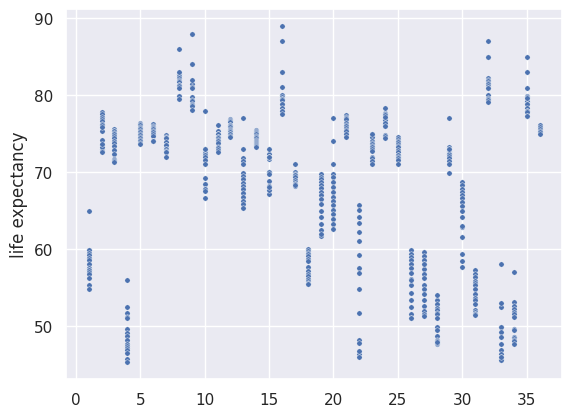

In [78]:
country_encode = {}
code = 1

# fill encode dict with values
for val in data['country']:
    if val not in country_encode:
        country_encode[val] = code
        code += 1

# scatter plot
sns.scatterplot(x=[country_encode[x] for x in data['country']], y=data[target], s=15)
plt.show()

Z grafu rozhodně není vidět lineární korelace. Ovšem i tak by mohl příznak `country` ovlivňovat vysvětlovanou proměnnou.
Zkusíme tedy při tvorbě modelu použít *one-hot encoding*.

### Korelace numerických příznaků
Vykreslím heatmapu s korelačním koeficientem. Primárně nás bude zajímat korelace s vysvětlovanou proměnnou.

Dále bychom mohli zkoumat například kolinearitu příznaků.

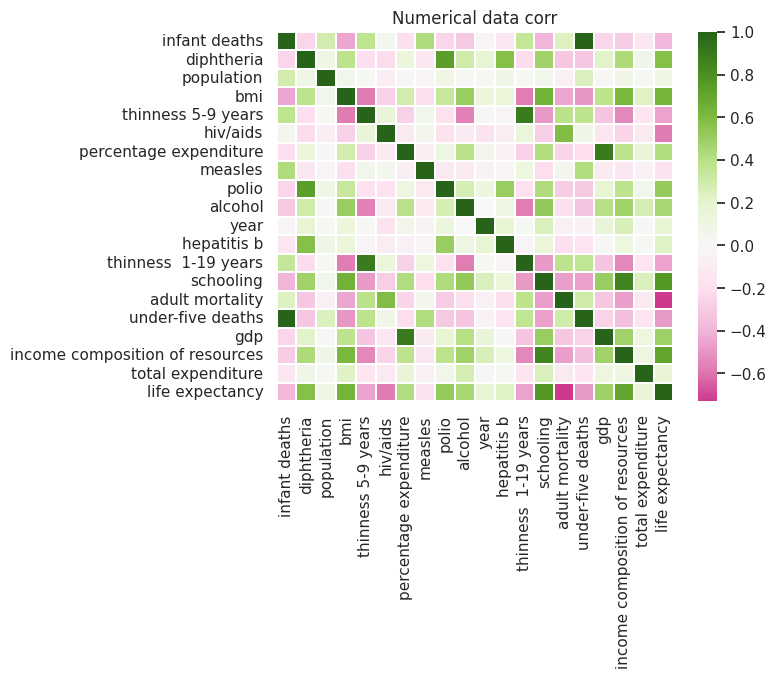

Features with corr coef higher than |x| > 0.5
diphtheria                         :  0.571                        
bmi                                :  0.639                        
hiv/aids                           : -0.58                         
polio                              :  0.514                        
schooling                          :  0.768                        
adult mortality                    : -0.731                        
income composition of resources    :  0.706                        


In [79]:
corr = data[numerical + [target]].corr()
coefs = corr[target]

# heatmap
sns.heatmap(corr, cmap='PiYG', center=0, linewidths=.1)
plt.title('Numerical data corr')
plt.show()

print("Features with corr coef higher than |x| > 0.5")
for feature, coef in zip(corr[:-1], coefs[:-1]):
    if abs(coef) > 0.5:
        print(f"{feature.strip(): <35}: {round(coef, 3): < 30}")

Z korelační heatmapy a výpisu korelačních koeficientů (větší než 0.5) můžeme vidět, že `Life Expectancy` primárně kladně koreluje s příznaky `BMI`, `Income composition of resources`, `Schooling` a negativně s `HIV/AIDS` a `Adult Mortality`.

Dalo by se tedy říct, že tyto příznaky budou mít největší vliv na predikci.

### Distribuce numerických spojitých příznaků
Zde můžeme zkoumat zda se příznaky podobají nějakému známému rozdělení, kolik mají odehlých hodnot a jak se ovlivňují navzájem.

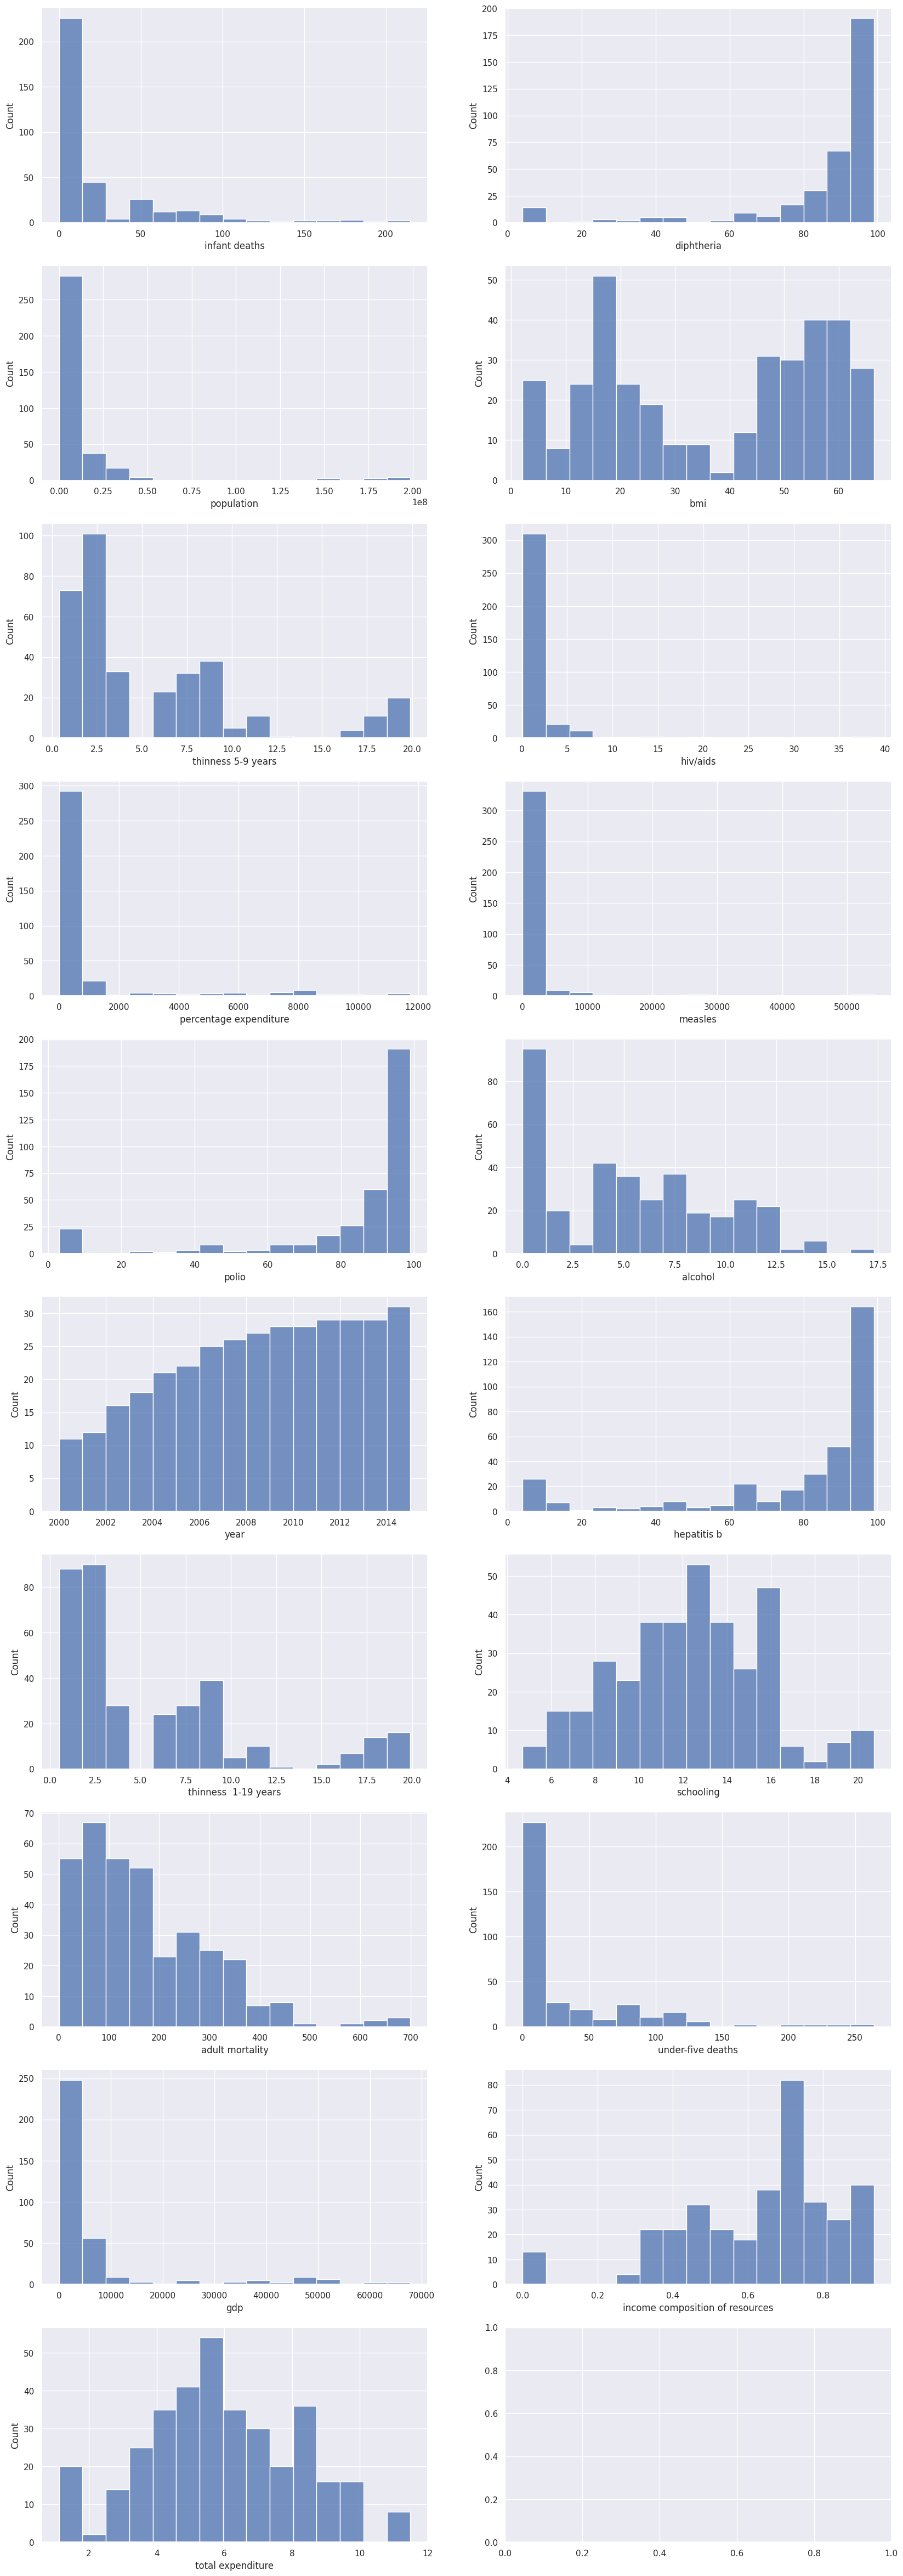

In [80]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

data_notnull = data.dropna()

for feature, subplot in zip(numerical, ax.flatten()):
    sns.histplot(data=data_notnull[feature], ax=subplot, bins=15)

Z histogramů numerických příznaků vyberu jen ty nejzajímavější poznatky.

`HIV/AIDS` -> Převážně se hodnota pohybuje mezi `[0,10]`. Zároveň je zde ale vysoká záporná korelace s vysvětlovanou proměnnou. Čili u té menšiny dat, kde je úmrtnost vysoká, tak by **mohla velmi ovlivňovat výslednou predikci**.

`Income composition of resources` -> Kladně korelovaný s *Life Expectancy*. Obsahuje nějaké nulové hodnoty, které by mohli narušovat následnou predikci.

`Schooling` -> Podobnost s normálním rozdělením a vysoká korelovanost s vysvětlovanou proměnnou by mohlo mít za výsledek predikci určenou primárně tímto příznakem.

### Závislost kvantitativních příznaků na `Life Expectancy`

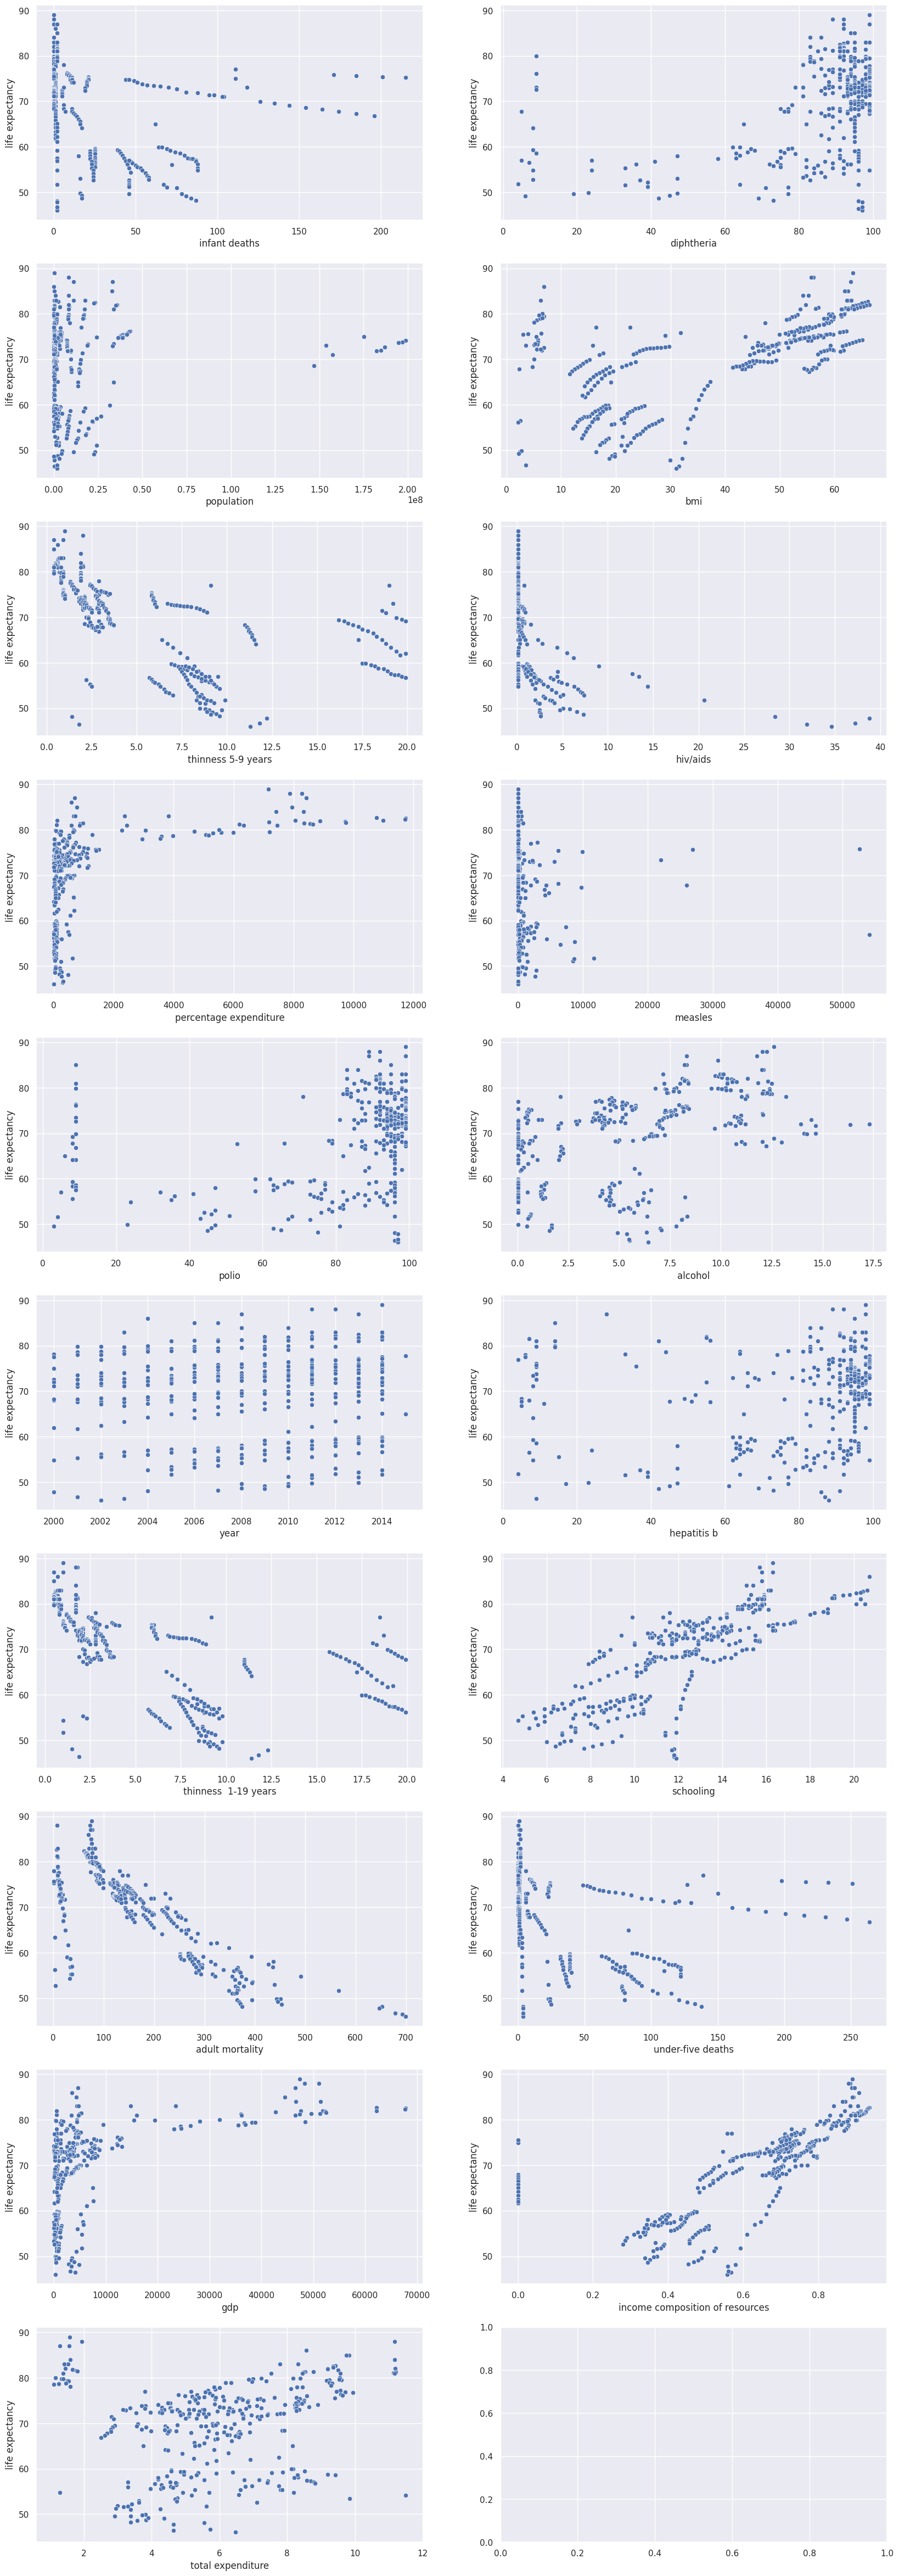

In [81]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

data_notnull = data.dropna()

for feature, subplot in zip(numerical, ax.flatten()):
    sns.scatterplot(x=data_notnull[feature], y=data_notnull[target], ax=subplot)

Z grafů je vidět, že: 
`Year` nám spíše o `Life Expectancy` nic neříká.
Příznaky jako `percentage expediture` a `GDP` jsou lehce podobné exponenciálnímu rozdělení.
U zbytku můžeme vidět převážně lineární korelaci a povětšinou nějaké množství nulových hodnot. 


### Odlehlé hodnoty

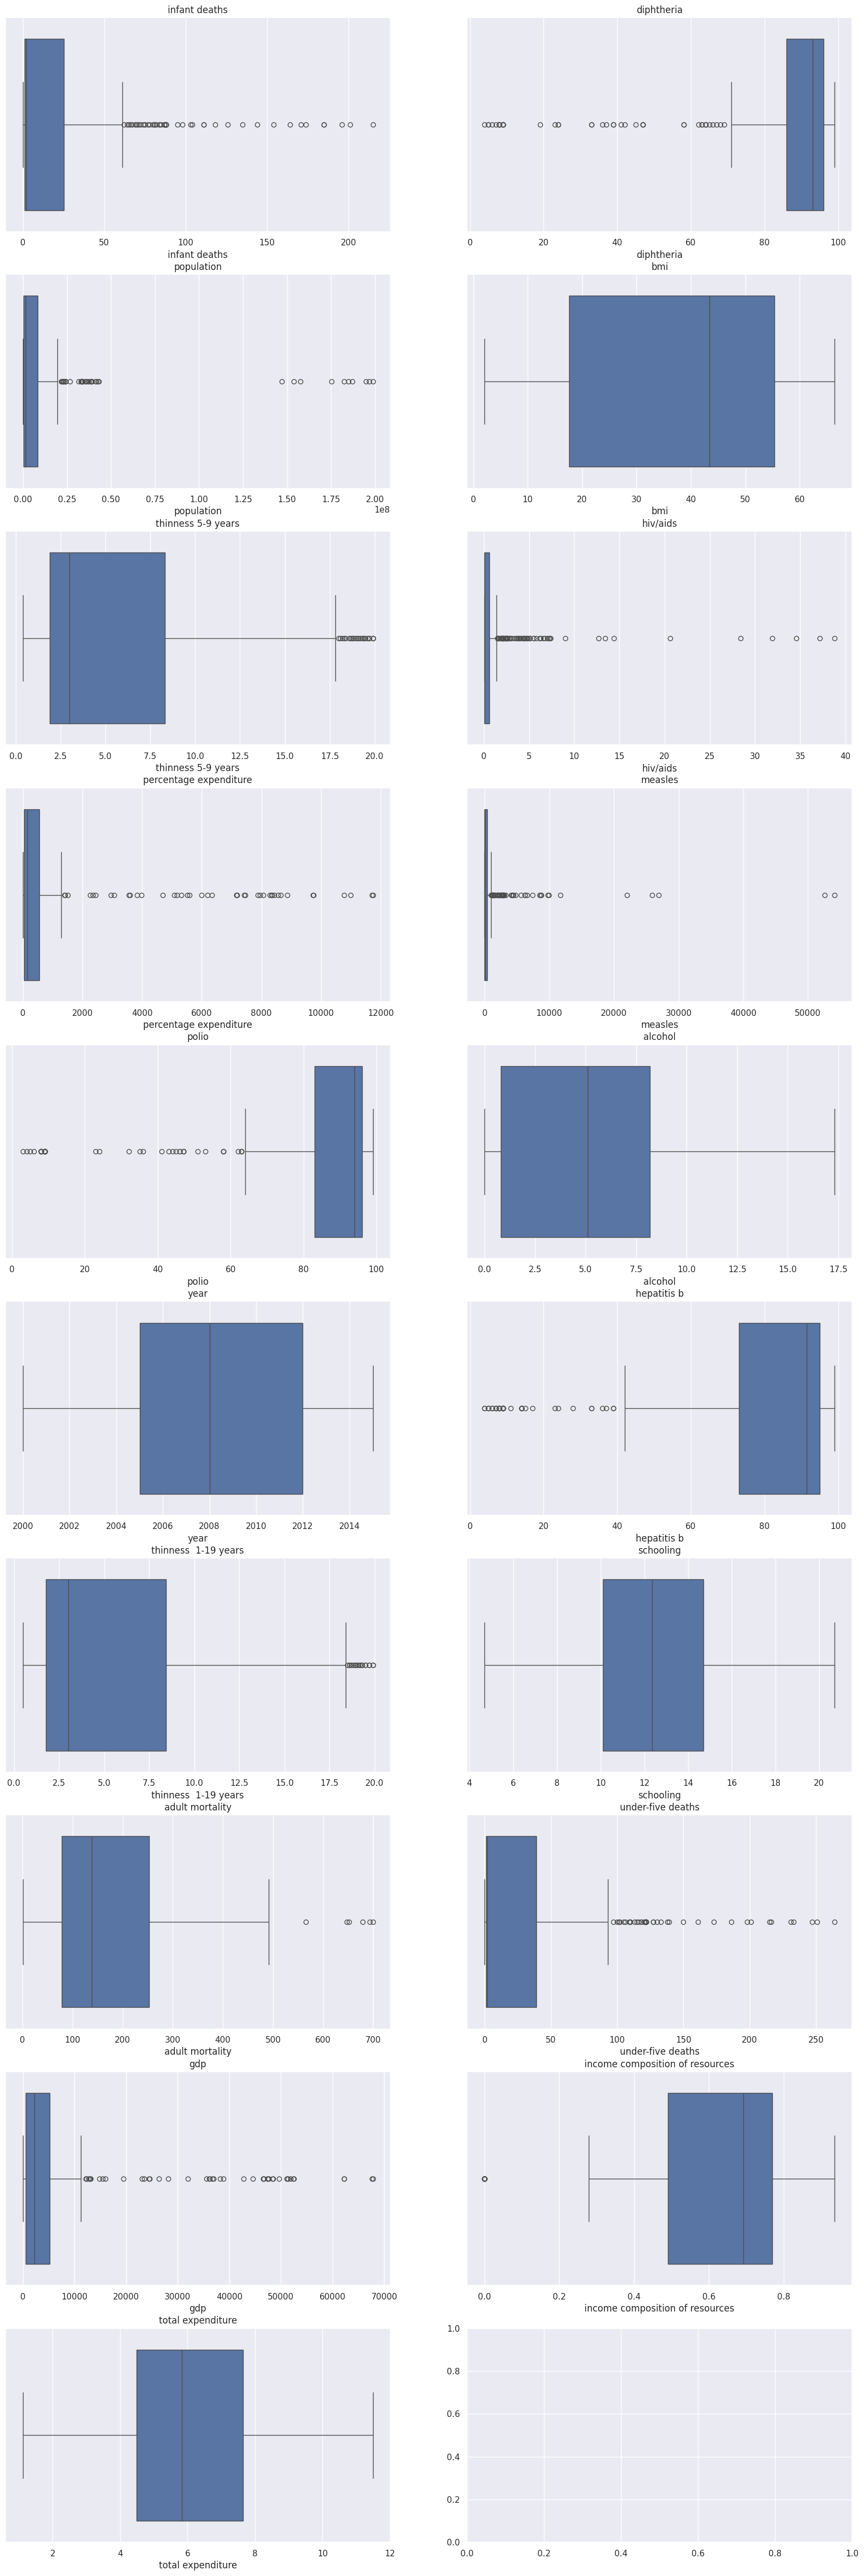

In [82]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

data_notnull = data.dropna()

for feature, subplot in zip(numerical, ax.flatten()):
    sns.boxplot(data_notnull[feature], ax=subplot, orient='h').set_title(feature)

Z boxplotů můžeme opět vidět distribuci příznaků a jejich odlehlé hodnoty. Zaměřím se na příznaky, které více korelují s `Life expectancy`.

`BMI` -> Neobsahuje odlehlé hodnoty a medián je přibližně **44**.

`Schooling` -> Bude se chovat přibližně jako normální rozdělení. Jak již bylo zjištěno z histogramu.

`Income composition of resources` -> Málo odlehlých hodnot.

`HIV/AIDS` -> Má korelaci s hodnotou **-0.557**. Obsahuje velké množství odlehlých hodnot a převážně se pohybuje okolo nuly.

`Adult Mortality` -> Odlehlé hodnoty existují nad hodnotou přibližně **450**.

### Kolinearita příznaků
Jelikož se jedná o regresní úlohu, tak by u některých modelů mohla dělat problém kolinearita příznaků.
Kolinearitu budu zkoumat opět pomocí korelační matice.
Pro každý příznak si vypíšu všechny příznaky s kterými má daný příznak korelační koeficient vyšší, než treshold **0.7**.

Případnou zjištěnou kolinearitu bychom chtěli buď vyřešit nebo použijeme **Hřebenovou regresi**, která problém kolinearity odstraňuje. 

In [83]:
corr = data[numerical].corr()

collinear = {}
threshold = 0.7

# fill collinear dict for each feature with corr coefs
for feature in numerical:
    collinear[feature] = list()
    for idx, coef in enumerate(corr[feature]):
        if abs(coef) > threshold and coef != 1:
            collinear[feature].append(round(coef, 3))
        else:
            collinear[feature].append(0)

# print each feature, which has correlation with another features
for feature, coefs in collinear.items():
    if sum(coefs) != 0:
        f_name = feature.strip()
        print(f"{f_name}:")

        for idx, coef in enumerate(coefs):
            if coef != 0:
                print(f"{numerical[idx].strip()} - {coef}")
        print('-' * 40) 


infant deaths:
under-five deaths - 0.989
----------------------------------------
diphtheria:
polio - 0.731
----------------------------------------
thinness 5-9 years:
thinness  1-19 years - 0.888
----------------------------------------
percentage expenditure:
gdp - 0.902
----------------------------------------
polio:
diphtheria - 0.731
----------------------------------------
thinness  1-19 years:
thinness 5-9 years - 0.888
----------------------------------------
schooling:
income composition of resources - 0.851
----------------------------------------
under-five deaths:
infant deaths - 0.989
----------------------------------------
gdp:
percentage expenditure - 0.902
----------------------------------------
income composition of resources:
schooling - 0.851
----------------------------------------


Kolinearitu jsme mohli vyčíst již z heatmapy výše. Ovšem takto vidíme explicitně korelační koeficienty mezi každou dvojicí příznaku u které je koef. větší než 0.7.

`thinness 1-19 years` a `thinness 5-9 years` jsou navzájem vysoce korelované. Řešením by mohlo být například vytvoření nového příznaku `thinness 1-19 years`, který bude obsahovat průměr obou hodnot.

`infant deaths` a `under-five deaths` jsou stejně jako *thinness* velmi korelované. V tomto případě můžeme jeden z příznaků smazat nebo nechat hřebenovou regresi, aby tento problém vyřešila za nás.

(`Schooling`, `Income composition of resources`) a (`percentage expenditure`, `GDP`) dosahují korelace 0.8 a 0.899. Zde se nabízí buď odstranění vždy jednoho z příznaků nebo opět zanechání a následné ladění hyperparametrů hřebenové regrese.

## Rozdělení na trénovací, validační a testovací množinu
Data rozdělíme na 3 množiny z důvodu evaluace přesnosti modelu a navíc odstraníme příznak `Year`, který nám o vysvětlované proměnné nic neříkal.

In [84]:
from sklearn.model_selection import train_test_split

seed = 42
X = data.drop([target, 'year'], axis=1)
y = data[target]

# split data onto train, val, test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=seed)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.2)

print('Train:', Xtrain.shape)
print('Val:', Xval.shape)
print('Test:', Xtest.shape)

Train: (361, 20)
Val: (91, 20)
Test: (114, 20)


## Zpracování příznaků
Pro každou úpravu datasetu vytvoříme funkci tak, aby byla následně snadno aplikovatelná na tyto disjunktní množiny. Tím zamezíme kontaminaci např. u nahrazování null hodnot mediánem.

### Kolinearita příznaků

#### Thinness
Příznaky `thiness 1-19 years` a `thinness 5-9 years` jsou vysoce korelované.
Proto vytvoříme nový příznak, který bude jejich průměrem a odstraníme dva předchozí.

In [85]:
def parse_thinness(df, remove=True):
    """ Add avg of thinness and remove old features """

    def thinness_avg(df):
        """ Return thinness avg series """
        df = df.copy()

        # get both columns
        thin_f = df['thinness  1-19 years']
        thin_s = df['thinness 5-9 years']

        # return average column
        return pd.Series([
            round((x + y) / 2, 3) for x, y in zip(thin_f, thin_s)
        ])

    # add thinness feature to dataframe
    df = df.copy()
    df['thinness'] = thinness_avg(df)

    if remove:
        df = df.drop(['thinness  1-19 years', 'thinness 5-9 years'], axis=1)

    return df

In [86]:
Xtrain = parse_thinness(Xtrain)
Xval = parse_thinness(Xval)
Xtest = parse_thinness(Xtest)

### Doplňení null hodnot
U numerických příznaků doplním chybějící hodnoty mediánem.
Kategorické příznaky chybějící hodnoty neobsahují.

In [87]:
def fill_numerical_null_values(df, fill=True):
    """ Fill numerical values by median"""

    def fill_feature(feature):
        """ Fill feature missing values by its median """

        median = df[feature].median()
        
        # get missing values indexes
        null_indexes = list(df[feature][df[feature].isnull()].index)
        if len(null_indexes) == 0:
            return df

        if fill:
            # replace each missing value with median
            for i in null_indexes:
                df.loc[i, feature] = median
        
        return df
    
    df = df.copy()

    # get null values column names
    null_features = list(df.columns[df.isna().any()])

    for feature in null_features:
        df = fill_feature(feature)

    return df

In [88]:
# use fill null values func on each set of data
Xtrain = fill_numerical_null_values(Xtrain)
Xval = fill_numerical_null_values(Xval)
Xtest = fill_numerical_null_values(Xtest)

# func validation
for x in [Xtrain, Xval, Xtest]:
    assert x.isna().sum().sum() == 0

print('All null values replaced')

All null values replaced


### Zpracování numerických spojitých příznaků
Vybereme tedy všechny numerické příznaky a vytvořím pipeline obsahující standardizaci.

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

# get names of quantitative features
num_features = list(set(Xtrain.columns) - set([*categorical, target]))

# create standard transformer
num_scale_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# create normalizer transformer
num_norm_transformer = Pipeline([
    ('norm', Normalizer())
])

### Zpracování kategorických příznaků
Na všechny příznaky aplikuji **one-hot encoder** a to z důvodu zachování informace o zemi a statusu při trénování modelu.

In [90]:
from sklearn.preprocessing import OneHotEncoder

cat_features = categorical
cat_transformer = Pipeline([
    ('onehot', OneHotEncoder())
])

## Výběr a trénování modelu
K predikci použiju **Lineární regresi** a **Hřebenovou regresi**. U obou těchto modelů budeme zkoušet normalizaci a případné ladění hyperparametrů.

### Lineární regrese
Lineární regrese sama o sobě žádné zajímavé hyperparametry nemá. Proto se nabízí experimentovat s předzpracováním dat.
Nátrénuji tedy dva regresní modely. Jeden bez standardizace a druhý s ní. Následně podle *RMSE* vyberu ten lepší.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['country', 'status']),
                                                 ('num_scale',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['infant deaths',
                                                   'diphtheria', 'population',
                                                   'bmi', 'hiv/aids',
                                                   'percentage expenditure',
                                                   'measles', 'polio',
                                                   'alcohol', 'hepatitis b',
                                                   'schooling',
                                                   'adult mortality',
                                                   'under-five deaths', 'gdp',
                                                   'income composition of '
                                                   'resources',
                                                   'total expenditure',
                                                   'thinness'])])),
                ('reg', LinearRegression())])

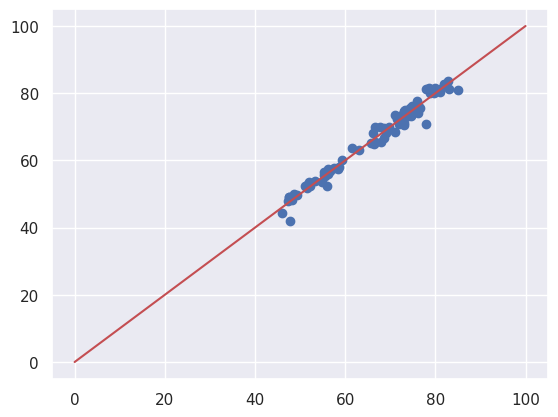

Score: 0.9762
RMSE: 1.687
MAE: 1.2351


In [91]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

preprocessors, rmse_scores = [], []

# create preprocessors combinations
preprocessors.append(ColumnTransformer([
    ('categorical', cat_transformer, cat_features)
]))

preprocessors.append(ColumnTransformer([
    ('categorical', cat_transformer, cat_features),
    ('num_scale', num_scale_transformer, num_features)
]))

preprocessors.append(ColumnTransformer([
    ('categorical', cat_transformer, cat_features),
    ('num_norm', num_norm_transformer, num_features)
]))

preprocessors.append(ColumnTransformer([
    ('categorical', cat_transformer, cat_features),
    ('num_scale', num_scale_transformer, num_features),
    ('num_norm', num_norm_transformer, num_features)
]))

preprocessors.append(ColumnTransformer([
    ('categorical', cat_transformer, cat_features),
    ('num_norm', num_norm_transformer, num_features),
    ('num_scale', num_scale_transformer, num_features)
]))

# try preprocessors and save rmse for each combination
for prep in preprocessors:
    reg = Pipeline([
        ('preprocessor', prep),
        ('reg', LinearRegression())
    ])

    reg.fit(Xtrain, ytrain)
    rmse_scores.append(mean_squared_error(np.array(yval), reg.predict(Xval), squared=False))

# select best preprocessing based on rmse
best_rmse = min(rmse_scores)
opt_reg_linear = Pipeline([
    ('preprocessor', preprocessors[rmse_scores.index(best_rmse)]),
    ('reg', LinearRegression())
])

# fit optimalized model
opt_reg_linear.fit(Xtrain, ytrain)
Yth = opt_reg_linear.predict(Xval)

display(opt_reg_linear)

# plot regression
plt.scatter(yval, Yth)
plt.plot([0,100], [0,100], 'r')
plt.show()

print('Score:', round(opt_reg_linear.score(Xval, yval), 4))
print('RMSE:', round(mean_squared_error(np.array(yval), Yth, squared=False), 4))
print('MAE:', round(mean_absolute_error(np.array(yval), Yth), 4))

Můžeme pozorovat, že byl vybrán model pouze se standardizací numerických dat.
S tímto modelem dosahujeme poměrně dobrých výsledků na validačních datech. Čili můžeme předpokládat, že standardizace na tomto datasetu obecně bude pomáhat s přesnější predikcí.

V dalších modelech proto budeme standardizaci aplikovat už v základu.

### Hřebenová regrese
Tento model by se měl zbavit případných problémů s kolinearitou.
Zároveň u hřebenové regrese můžeme ladit parametr *alpha*.

Použijeme tedy one-hot encoding, standardizaci a následně budeme optimalizovat parametry pomocí **GridSearchCV**, který aplikuje i křížovou validaci.

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['country',
                                                                          'status']),
                                                                        ('num_scale',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['infant '
                                                                          'deaths',
                                                                          'diphtheria',
                                                                          'population',
                                                                          'bmi',
                                                                          'hiv/aids',
                                                                          'percentage '
                                                                          'expenditure',
                                                                          'measles',
                                                                          'polio',
                                                                          'alcohol',
                                                                          'hepati...
       0.08308543, 0.08358291, 0.0840804 , 0.08457789, 0.08507538,
       0.08557286, 0.08607035, 0.08656784, 0.08706533, 0.08756281,
       0.0880603 , 0.08855779, 0.08905528, 0.08955276, 0.09005025,
       0.09054774, 0.09104523, 0.09154271, 0.0920402 , 0.09253769,
       0.09303518, 0.09353266, 0.09403015, 0.09452764, 0.09502513,
       0.09552261, 0.0960201 , 0.09651759, 0.09701508, 0.09751256,
       0.09801005, 0.09850754, 0.09900503, 0.09950251, 0.1       ])})

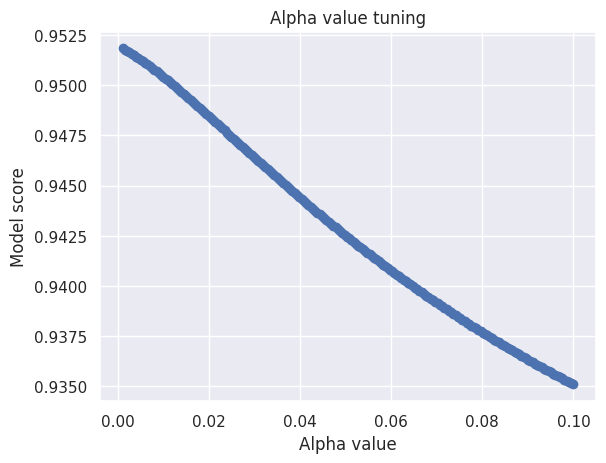

Best alpha: 0.001


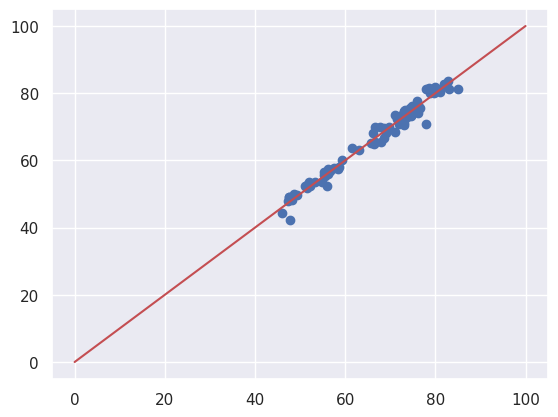

Score: 0.9764
RMSE: 1.6795
MAE: 1.2311


In [92]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_features),
    ('num_scale', num_scale_transformer, num_features)
])

params = {
    'ridge__alpha' : np.linspace(0.001, 0.1, 200)
}

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

# find best hyperparams using grid search with cross validation
opt_reg_ridge = GridSearchCV(pipe, param_grid=params)
opt_reg_ridge.fit(Xtrain, ytrain)

Yth = opt_reg_ridge.predict(Xval)

# show model parts
display(opt_reg_ridge)

# plot alpha param tuning
alphas = [x['ridge__alpha'] for x in opt_reg_ridge.cv_results_['params']]
score_mean = opt_reg_ridge.cv_results_['mean_test_score']

# plot alpha tuning
plt.plot(alphas, score_mean, 'o')
plt.title('Alpha value tuning')
plt.ylabel('Model score')
plt.xlabel('Alpha value')
plt.show()
print('Best alpha:', opt_reg_ridge.best_params_['ridge__alpha'])

# plot data with regression
plt.scatter(yval, Yth)
plt.plot([0,100], [0,100], 'r')
plt.show()

print('Score:', round(opt_reg_ridge.score(Xval, yval), 4))
print('RMSE:', round(mean_squared_error(np.array(yval), Yth, squared=False), 4))
print('MAE:', round(mean_absolute_error(np.array(yval), Yth), 4))


I přes optimalizaci parametru *alpha* a standardizaci dat jsme dosáhli lehce horšího výsledku než u běžné lineární regrese.

### Random Forest Regressor
Lepšího výsledku bychom mohli dosáhnout ještě pomocí ensamble metod. Konkrétně pomocí modelu **Random forest regressor**, který používá metodu bagging. Ten kombinuje vetší počet nezávislých regresních stromů. Každý z těchto stromů udělá svojí predikci a výsledná predikce je průměrem těchto hodnot.

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['country',
                                                                          'status']),
                                                                        ('num_scale',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['infant '
                                                                          'deaths',
                                                                          'diphtheria',
                                                                          'population',
                                                                          'bmi',
                                                                          'hiv/aids',
                                                                          'percentage '
                                                                          'expenditure',
                                                                          'measles',
                                                                          'polio',
                                                                          'alcohol',
                                                                          'hepatitis '
                                                                          'b',
                                                                          'schooling',
                                                                          'adult '
                                                                          'mortality',
                                                                          'under-five '
                                                                          'deaths',
                                                                          'gdp',
                                                                          'income '
                                                                          'composition '
                                                                          'of '
                                                                          'resources',
                                                                          'total '
                                                                          'expenditure',
                                                                          'thinness'])])),
                                       ('forest', RandomForestRegressor())]),
             param_grid={'forest__max_samples': [1, 0.9, 0.8],
                         'forest__n_estimators': [100, 150, 200],
                         'forest__n_jobs': [-1]})

Best params: {'forest__max_samples': 0.8, 'forest__n_estimators': 150, 'forest__n_jobs': -1}


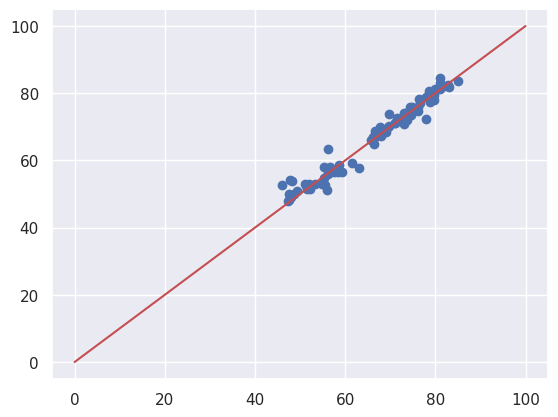

Score: 0.9639
RMSE: 2.0765
MAE: 1.3483


In [93]:
from sklearn.ensemble import RandomForestRegressor

preprocessor = ColumnTransformer([
    ('categorical', cat_transformer, cat_features),
    ('num_scale', num_scale_transformer, num_features)
])

params = {
    'forest__n_jobs' : [-1],
    'forest__n_estimators' : [100, 150, 200],
    'forest__max_samples' : [1, 0.9, 0.8]
    
}

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('forest', RandomForestRegressor())
])

opt_reg_forest = GridSearchCV(pipe, param_grid=params, cv=3)
opt_reg_forest.fit(Xtrain, ytrain)

Yth = opt_reg_forest.predict(Xval)

# show model components and best params
display(opt_reg_forest)
print('Best params:', opt_reg_forest.best_params_)

plt.scatter(yval, Yth)
plt.plot([0,100], [0,100], 'r')
plt.show()

print('Score:', round(opt_reg_forest.score(Xval, yval), 4))
print('RMSE:', round(mean_squared_error(np.array(yval), Yth, squared=False), 4))
print('MAE:', round(mean_absolute_error(np.array(yval), Yth), 4))

S tímto modelem jsme měli doposud nejlepší RMSE.

## Výběr modelu
Na validačních datech si nejlépe vedl **Random forest regressor**. Použijeme tedy tento model a ověříme jeho přesnost na testovacích datech.

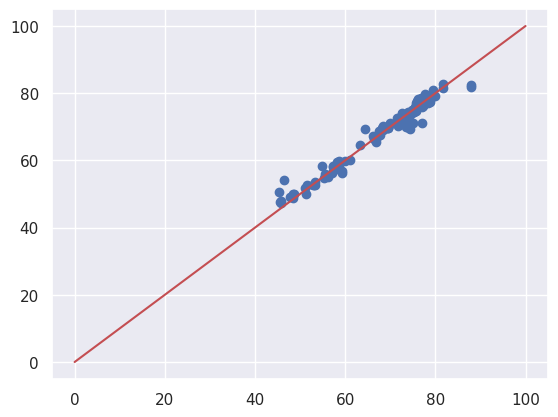

Score: 0.9642
RMSE: 1.9504
MAE: 1.2848


In [94]:
Yth_test = opt_reg_forest.predict(Xtest)

plt.scatter(ytest, Yth_test)
plt.plot([0,100], [0,100], 'r')
plt.show()

print('Score:', round(opt_reg_forest.score(Xtest, ytest), 4))
print('RMSE:', round(mean_squared_error(np.array(ytest), Yth_test, squared=False), 4))
print('MAE:', round(mean_absolute_error(np.array(ytest), Yth_test), 4))

Na testovacích datech si náš vybraný model vedl ještě lépe, než na těch validačních.